# def

* This is an example code to access sensitive detector modules and generate random position on module --> random cell ID. It can be used to inspect the geometry component, and create random sensor noise for a given epic geometry. 

* Please start the jupyter server within eic-shell.

Shujie Li, 082025


In [ ]:
import dd4hep
import numpy as np
from dd4hep import DetElement, VolumeManager
import ROOT
import DDRec
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os

# Get DETECTOR_PATH
detector_path = os.environ.get('DETECTOR_PATH')
xml_path      = detector_path+"/epic_craterlake_tracking_only.xml"
detector = dd4hep.Detector.getInstance()
detector.fromCompact(xml_path)
converter = DDRec.CellIDPositionConverter(detector)


In [3]:

def random_point_in_volume(shape):
    """
    Generate a random point inside a TGeo shape volume.
    
    Args:
        shape: TGeo shape object with .type() and .dimensions() methods
        
    Returns:
        tuple: (x, y, z) coordinates of random point inside the volume
    """
    
    shape_type = shape.type()
    dims = shape.dimensions()
    
    if shape_type == "TGeoTrd2":
        # TRD2: [dx1, dx2, dy1, dy2, dz]
        dx1, dx2, dy1, dy2, dz = dims[0], dims[1], dims[2], dims[3], dims[4]
        
        # Random z coordinate
        z = random.uniform(-dz, dz)
        
        # Linear interpolation factor
        t = (z + dz) / (2 * dz)
        
        # Interpolate half-widths at this z
        dx_z = dx1 + t * (dx2 - dx1)
        dy_z = dy1 + t * (dy2 - dy1)
        
        # Random x, y within interpolated bounds
        x = random.uniform(-dx_z, dx_z)
        y = random.uniform(-dy_z, dy_z)
        
        return x, y, z
    
    elif shape_type == "TGeoBBox" or shape_type == "Box":
        # Box: [dx, dy, dz] (half-widths)
        dx, dy, dz = dims[0], dims[1], dims[2]
        
        x = random.uniform(-dx, dx)
        y = random.uniform(-dy, dy)
        z = random.uniform(-dz, dz)
        
        return x, y, z
    
    elif shape_type == "TGeoTube" or shape_type == "Tube":
        # Tube: [rmin, rmax, dz]
        rmin, rmax, dz = dims[0], dims[1], dims[2]
        
        # Random cylindrical coordinates
        r = math.sqrt(random.uniform(rmin*rmin, rmax*rmax))  # Uniform in area
        phi = random.uniform(0, 2 * math.pi)
        z = random.uniform(-dz, dz)
        
        # Convert to Cartesian
        x = r * math.cos(phi)
        y = r * math.sin(phi)
        
        return x, y, z
    
    elif shape_type == "TGeoTubs" or shape_type == "Tubs":
        # Tube segment: [rmin, rmax, dz, phi1, phi2]
        rmin, rmax, dz, phi1, phi2 = dims[0], dims[1], dims[2], dims[3], dims[4]
        
        # Convert angles to radians if needed
        phi1_rad = math.radians(phi1) if phi1 > 2*math.pi else phi1
        phi2_rad = math.radians(phi2) if phi2 > 2*math.pi else phi2
        
        # Random cylindrical coordinates
        r = math.sqrt(random.uniform(rmin*rmin, rmax*rmax))
        phi = random.uniform(phi1_rad, phi2_rad)
        z = random.uniform(-dz, dz)
        
        # Convert to Cartesian
        x = r * math.cos(phi)
        y = r * math.sin(phi)
        
        return x, y, z
    
    elif shape_type == "TGeoSphere" or shape_type == "Sphere":
        # Sphere: [rmin, rmax, theta1, theta2, phi1, phi2]
        if len(dims) >= 6:
            rmin, rmax, theta1, theta2, phi1, phi2 = dims[:6]
        else:
            rmin, rmax = dims[0], dims[1]
            theta1, theta2 = 0, 180  # Full sphere in theta
            phi1, phi2 = 0, 360      # Full sphere in phi
        
        # Convert angles to radians
        theta1_rad = math.radians(theta1) if theta1 > 2*math.pi else theta1
        theta2_rad = math.radians(theta2) if theta2 > 2*math.pi else theta2
        phi1_rad = math.radians(phi1) if phi1 > 2*math.pi else phi1
        phi2_rad = math.radians(phi2) if phi2 > 2*math.pi else phi2
        
        # Random spherical coordinates
        r = (rmin**3 + random.random() * (rmax**3 - rmin**3))**(1/3)  # Uniform in volume
        cos_theta = math.cos(theta1_rad) + random.random() * (math.cos(theta2_rad) - math.cos(theta1_rad))
        theta = math.acos(cos_theta)
        phi = random.uniform(phi1_rad, phi2_rad)
        
        # Convert to Cartesian
        x = r * math.sin(theta) * math.cos(phi)
        y = r * math.sin(theta) * math.sin(phi)
        z = r * math.cos(theta)
        
        return x, y, z
    
    elif shape_type == "TGeoCone" or shape_type == "Cone":
        # Cone: [dz, rmin1, rmax1, rmin2, rmax2]
        dz, rmin1, rmax1, rmin2, rmax2 = dims[0], dims[1], dims[2], dims[3], dims[4]
        
        # Random z coordinate
        z = random.uniform(-dz, dz)
        
        # Linear interpolation factor
        t = (z + dz) / (2 * dz)
        
        # Interpolate radii at this z
        rmin_z = rmin1 + t * (rmin2 - rmin1)
        rmax_z = rmax1 + t * (rmax2 - rmax1)
        
        # Random cylindrical coordinates
        r = math.sqrt(random.uniform(rmin_z*rmin_z, rmax_z*rmax_z))
        phi = random.uniform(0, 2 * math.pi)
        
        # Convert to Cartesian
        x = r * math.cos(phi)
        y = r * math.sin(phi)
        
        return x, y, z
    
    elif shape_type == "TGeoTrd1" or shape_type == "Trd1":
        # TRD1: [dx1, dx2, dy, dz] (trapezoid in x only)
        dx1, dx2, dy, dz = dims[0], dims[1], dims[2], dims[3]
        
        # Random z coordinate
        z = random.uniform(-dz, dz)
        
        # Linear interpolation for x
        t = (z + dz) / (2 * dz)
        dx_z = dx1 + t * (dx2 - dx1)
        
        # Random coordinates
        x = random.uniform(-dx_z, dx_z)
        y = random.uniform(-dy, dy)
        
        return x, y, z
    
    elif shape_type == "TGeoEltu" or shape_type == "Eltu":
        # Elliptical tube: [a, b, dz] where a, b are semi-axes
        a, b, dz = dims[0], dims[1], dims[2]
        
        # Generate point in ellipse using rejection method
        while True:
            x = random.uniform(-a, a)
            y = random.uniform(-b, b)
            if (x/a)**2 + (y/b)**2 <= 1:
                break
        
        z = random.uniform(-dz, dz)
        return x, y, z
    
    elif shape_type == "TGeoTrap" or shape_type == "Trap":
        # General trapezoid - more complex, simplified version
        # Trap: [dz, theta, phi, h1, bl1, tl1, alpha1, h2, bl2, tl2, alpha2]
        # Simplified: treat as box with average dimensions
        if len(dims) >= 11:
            dz = dims[0]
            h1, h2 = dims[3], dims[7]
            bl1, tl1 = dims[4], dims[5]
            bl2, tl2 = dims[8], dims[9]
            
            # Use average dimensions (simplified)
            dx = (bl1 + tl1 + bl2 + tl2) / 4
            dy = (h1 + h2) / 2
            
            x = random.uniform(-dx, dx)
            y = random.uniform(-dy, dy)
            z = random.uniform(-dz, dz)
            
            return x, y, z
    
    else:
        # Fallback for unknown shapes - try to treat as box
        print(f"Warning: Unknown shape type '{shape_type}', treating as box")
        if len(dims) >= 3:
            dx, dy, dz = dims[0], dims[1], dims[2]
            x = random.uniform(-dx, dx)
            y = random.uniform(-dy, dy)
            z = random.uniform(-dz, dz)
            return x, y, z
        else:
            raise ValueError(f"Unsupported shape type: {shape_type} with dimensions: {dims}")

# Helper function for multiple points
def random_points_in_volume(shape, n_points):
    """Generate multiple random points in a volume"""
    points = []
    for _ in range(n_points):
        points.append(random_point_in_volume(shape))
    return points


# analysis

## get random position and cell ID for a given detector

In [3]:
for i,j in detector.sensitiveDetectors():
	print(i)

B0ECal
B0Tracker
BackwardMPGD
BackwardsTaggerStation
BarrelTOF
ForwardMPGD
ForwardOffMTracker_station_1
ForwardOffMTracker_station_2
ForwardOffMTracker_station_3
ForwardOffMTracker_station_4
ForwardRomanPot_Station_1
ForwardRomanPot_Station_2
ForwardTOF
HcalFarForwardZDC_SiPMonTile
InnerMPGDBarrel
InnerTrackerEndcapN
InnerTrackerEndcapP
LumiDirectPCAL
LumiSpecCAL
LumiSpecTracker
MPGDOuterBarrel
MiddleTrackerEndcapN
MiddleTrackerEndcapP
OuterSiBarrel
OuterTrackerEndcapN
OuterTrackerEndcapP
SagittaSiBarrel
VertexBarrel
ZDC_Crystal


In [ ]:
# detector_name =  "MiddleTrackerEndcapP"
detector_name = "VertexBarrel"
dd=detector.detector(detector_name)

## detector->layer->detector element (module)->placement->component->sensitive volume
for dtemp, _ in dd.children():
    print(dtemp)
    ll=dd.child(dtemp) ## layer
    for ltemp,_ in ll.children(): 
        print(ltemp)
        de=ll.child(ltemp) ## detector element (module)
        pl=de.placement() ## placement
        n_daughters = pl.ptr().GetNdaughters() ## number of components per de
        for ii in np.arange(n_daughters):
            comp = pl.daughter(int(ii)) ## component
            if comp.volume().isSensitive(): ## assume only one sensitive component per module
                print(comp.name()," is sensitive")
                offset = comp.position() ## xyz offset of the component wrt the module center (local coordinate)
                print("\tlocal offset [cm]: ", offset.x(),offset.y(),offset.z())
                vv=comp.volume().solid() ## component shape
                print("\tshape: ", vv.type(), vv.dimensions())
                ## get a random point within the comp vol, then local --> global --> cellID
                print("\tgenerate ramdom hit:")
                x,y,z=random_point_in_volume(vv)
                local_pos  = ROOT.dd4hep.Position(x,y,z)+offset
                print("\t\tlocal coord ( with offset): ", local_pos.x(),local_pos.y(),local_pos.z())
                global_pos = de.nominal().localToWorld(local_pos) ## cm
                print("\t\tglobal coord (from local) : ", global_pos.x(),global_pos.y(),global_pos.z())
                cid=converter.cellID(global_pos)
                print("\t\tCell ID: ", bin(cid))
                pp=converter.position(cid)
                print("\t\tglobal coord (from cellID): ", pp.x(),pp.y(),pp.z())
        ## tbd: loop over layers and pick random points wrt their rates 
        break



VertexBarrel_layer1
module1
component0_0  is sensitive
	local offset [cm]:  0.0 0.0 0.0
	shape:  TGeoBBox { 0.088375040, 13.500000, 0.0020000000 }
	generate ramdom hit:
		local coord ( with offset):  0.07891977012456126 3.2334660085878824 0.001675315310801563
		global coord (from local) :  3.6016753153108017 -0.07891977012456107 -3.2334660085878824
		Cell ID:  0b11001010001000000000010011100000001000000000001000100011111
		global coord (from cellID):  3.6 -0.0779999999999998 -3.234
VertexBarrel_layer2
module1
component0_0  is sensitive
	local offset [cm]:  0.0 0.0 0.0
	shape:  TGeoBBox { 0.11783339, 13.500000, 0.0020000000 }
	generate ramdom hit:
		local coord ( with offset):  0.09520108098441747 9.405985024675164 0.0004767279434898437
		global coord (from local) :  4.800476727943489 -0.09520108098441689 -9.405985024675164
		Cell ID:  0b1001001011111000000000011000000000001000000000001001000011111
		global coord (from cellID):  4.8 -0.09599999999999942 -9.406
VertexBarrel_layer4
module

Warning in <TGeoMatrix::dtor>: Registered matrix component0_placement was removed
Warning in <TGeoMatrix::dtor>: Registered matrix component0_placement was removed
Warning in <TGeoMatrix::dtor>: Registered matrix component0_placement was removed


## get segmentation index range for endcap trd2
use de and offset from previous section

In [311]:
sens = detector.sensitiveDetector(detector_name)
decoder = sens.readout().idSpec().decoder()
# de.volumeID()
# idDesc["system"].value(volID)
# decoder.fields()[5].name()
# sens.readout().segmentation().segmentation().gridSizeX()


In [299]:
yy = 0 ## ignore y dim for now
lx=[]
ly=[]
lz=[]
lsegx=[]
lsegz=[]
lc=[]
for zz in np.arange(-z,z,0.1):
    # Linear interpolation factor
    dz   = zz+z
    dx_z = (x2-x1)/2/z
    xlim = dx_z*dz+x1
    for xx in np.arange(-xlim,xlim,seg_x):
        local_pos  = ROOT.dd4hep.Position(xx,yy,zz)+offset
        global_pos = de.nominal().localToWorld(local_pos)
        cid=converter.cellID(global_pos)
        lx.append(xx)
        ly.append(yy)
        lz.append(zz)
        lsegx.append(decoder["x"].value(cid))
        lsegz.append(decoder["z"].value(cid))
        lc.append(cid)
df=pd.DataFrame({"x":lx,"y":ly,"z":lz,"segx":lsegx,"segz":lsegz,"cell_id":lc})

Text(0, 0.5, 'seg z')

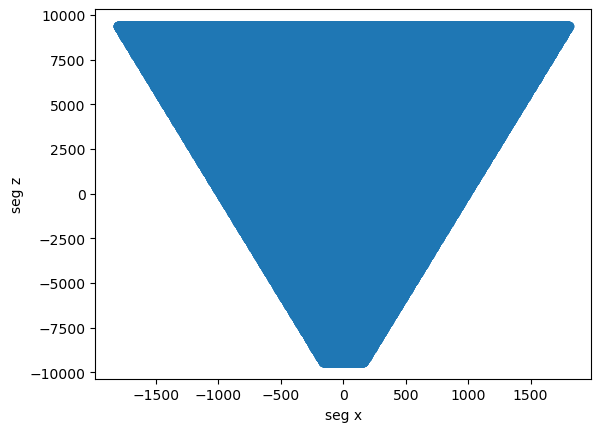

In [310]:
plt.scatter(df.segx,df.segz)
plt.xlabel("seg x")
plt.ylabel("seg z")

## get neighbour cell ID for a given cell

In [4]:

sens = detector.sensitiveDetector(detector_name)
neighbours = ROOT.std.set("dd4hep::CellID")()
sens.readout().segmentation().neighbours(cellID, neighbours)

converter = DDRec.CellIDPositionConverter(detector)

for nn in neighbours:
	pos=converter.position(nn)
	print(f"Cell ID {nn}, Position:",pos.x(),pos.y(),pos.z())

Cell ID 16845714603764658719, Position: 4.276590568660096 2.181567580444739 11.376
Cell ID 16845996074446402079, Position: 4.275647775186444 2.1833314229734357 11.374
Cell ID 16845996083036336671, Position: 4.277533362133748 2.1798037379160426 11.374
Cell ID 16846277553718080031, Position: 4.276590568660096 2.181567580444739 11.372
